In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

Loaded dataset: 1653 rows, 14 columns
Train size: 1322  Test size: 331

Baseline — AUC=1.000, F1=0.965
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters found:
{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.03, 'colsample_bytree': 0.8}

Retuned XGBoost — AUC=1.000, F1=0.970

Calibration Results:
Platt  — AUC=1.000, F1=0.970
Isotonic — AUC=0.999, F1=0.943


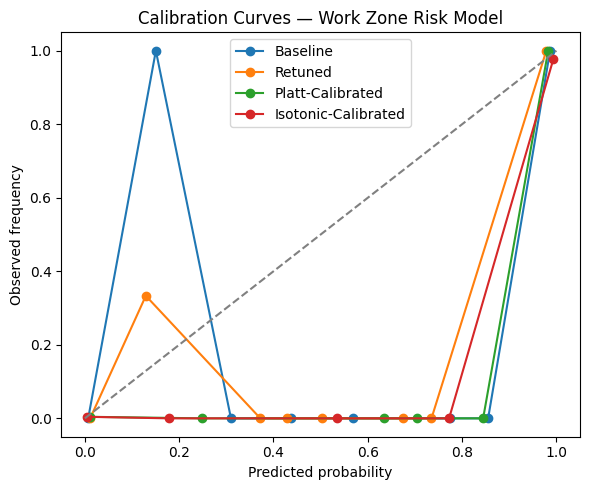

              Model      AUC       F1
           Baseline 0.999514 0.964706
            Retuned 0.999514 0.970414
   Platt-Calibrated 0.999514 0.970414
Isotonic-Calibrated 0.999126 0.942529

Classification Report (Best: Isotonic):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       248
           1       0.90      0.99      0.94        83

    accuracy                           0.97       331
   macro avg       0.95      0.98      0.96       331
weighted avg       0.97      0.97      0.97       331


Saved final calibrated model: xgb_final_calibrated.pkl


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings("ignore")

data_path = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
num_cols = [
    "duration_hr","avg_distance_km","avg_visibility_mi",
    "avg_temp_F","avg_wind_mph"
]
num_cols = [c for c in num_cols if c in df.columns]
X = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)
y = df["high_risk"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train size: {len(X_train)}  Test size: {len(X_test)}")
baseline = XGBClassifier(
    n_estimators=200, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8,
    random_state=42, eval_metric="auc"
)
baseline.fit(X_train, y_train)
preds_base = baseline.predict_proba(X_test)[:,1]
auc_base = roc_auc_score(y_test, preds_base)
f1_base = f1_score(y_test, (preds_base>0.5).astype(int))
print(f"\nBaseline — AUC={auc_base:.3f}, F1={f1_base:.3f}")

param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 0.3, 0.5],
    "reg_lambda": [0.5, 1.0, 1.5, 2.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=baseline,
    param_distributions=param_dist,
    n_iter=40, scoring="roc_auc",
    cv=cv, random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("\nBest parameters found:")
print(search.best_params_)

preds_best = best_model.predict_proba(X_test)[:,1]
auc_best = roc_auc_score(y_test, preds_best)
f1_best = f1_score(y_test, (preds_best>0.5).astype(int))
print(f"\nRetuned XGBoost — AUC={auc_best:.3f}, F1={f1_best:.3f}")

cal_platt = CalibratedClassifierCV(best_model, cv=cv, method="sigmoid")
cal_platt.fit(X_train, y_train)
preds_platt = cal_platt.predict_proba(X_test)[:,1]
auc_platt = roc_auc_score(y_test, preds_platt)
f1_platt = f1_score(y_test, (preds_platt>0.5).astype(int))

cal_iso = CalibratedClassifierCV(best_model, cv=cv, method="isotonic")
cal_iso.fit(X_train, y_train)
preds_iso = cal_iso.predict_proba(X_test)[:,1]
auc_iso = roc_auc_score(y_test, preds_iso)
f1_iso = f1_score(y_test, (preds_iso>0.5).astype(int))

print(f"\nCalibration Results:")
print(f"Platt  — AUC={auc_platt:.3f}, F1={f1_platt:.3f}")
print(f"Isotonic — AUC={auc_iso:.3f}, F1={f1_iso:.3f}")

plt.figure(figsize=(6,5))
for label, preds in [
    ("Baseline", preds_base),
    ("Retuned", preds_best),
    ("Platt-Calibrated", preds_platt),
    ("Isotonic-Calibrated", preds_iso)
]:
    prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=label)
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("Calibration Curves — Work Zone Risk Model")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
plt.show()

summary = pd.DataFrame({
    "Model": ["Baseline", "Retuned", "Platt-Calibrated", "Isotonic-Calibrated"],
    "AUC": [auc_base, auc_best, auc_platt, auc_iso],
    "F1": [f1_base, f1_best, f1_platt, f1_iso]
})
print(summary.to_string(index=False))
print("\nClassification Report (Best: Isotonic):")
print(classification_report(y_test, (preds_iso>0.5).astype(int)))
joblib.dump(cal_iso, "/work/siads_699_mads_capstone/data/models/xgb_final_calibrated.pkl")
print("\nSaved final calibrated model: xgb_final_calibrated.pkl")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>